<font size="+3"><strong>Polish Bankruptcy Prediction 🇵🇱 </strong></font>

<font size="+2"><strong>Part 4: Gradient Boosting Trees</strong></font>

In [1]:
__author__ = "Donald Ghazi"
__email__ = "donald@donaldghazi.com"
__website__ = "donaldghazi.com"

I'll start this project the same way I've started the others: preparing the data and building my model, and this time with a new ensemble model. Once it's working, I'll incorporate some new performance metrics to evaluate it. By the end of this project, I'll have written my first Python module.  

In [2]:
import gzip
import json
import pickle
import ipywidgets as widgets
import pandas as pd

from imblearn.over_sampling import RandomOverSampler
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

GOALS
 - Improve my bankruptcy model using gradient boosting.
 - Evaluate model using precision and recall.
 - Create an interactive dashboard.
 - Create a Python module to store my prediction function.

Machine Learning Workflow
 - Prepare Data
     - Import
     - Explore
     - Split
     - Resample
 - Build Model
     - Baseline
     - Iterate: Gradient boosting, grid search
         - boosting, weak learner
     - Evaluate: Precision, recall, dashboard
         - positive and negative class 
         - false negative, false positive
 - Communicate Results
     - Save model as file
     - Build my_predictor module

# Prepare Data

## Import

I'll write the `wrangle` function using the code I developed in the `Working with JSON files` project. Then I'll use it to import `poland-bankruptcy-data-2009.json.gz` into the DataFrame `df`.

In [3]:
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename, "r") as f:
        data = json.load(f)

    # Load dictionary into DataFrame, set index
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")
    
    return df

In [4]:
df = wrangle("data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


## Split

In [5]:
# Create my feature matrix X and target vector y
target = "bankrupt"            # My target is "bankrupt"
feature = "feat_27"
X = df.drop(columns="bankrupt")
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


In [6]:
# Divide my data (X and y) into training and test sets using a randomized train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42         # My test set should be 20% of my total data & set a random_state for reproducibility
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


## Resample

In [7]:
# Create a new feature matrix X_train_over and target vector y_train_over by performing random over-sampling on the training data
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


# Build Model

Now I'll put together my model. I'll start by calculating the baseline accuracy.

## Baseline

In [8]:
# Calculate the baseline accuracy score for my model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


## Iterate

Even though the building blocks are the same, here's where I start working with something new. First, I'm going to use a new type of ensemble model for my classifier. 

**Gradient Boosting Trees**

In [9]:
# Create a pipeline named clf (short for "classifier") that contains a SimpleImputer transformer and a GradientBoostingClassifier predictor
clf = make_pipeline(SimpleImputer(), GradientBoostingClassifier())

While I'm doing this, I only want to be looking at the *positive* class. Here, the positive class is the one where the companies really did go bankrupt. In the dictionary I made last time, the positive class is made up of the companies with the `bankrupt: true` key-value pair.

Next, I'm going to tune some of the hyperparameters for my model.

**Hyperparameter Grid**

I'll create a dictionary with the range of hyperparameters that I want to evaluate for my classifier. 

1. For the `SimpleImputer`, I'll try both the `"mean"` and `"median"` strategies. 
2. For the `GradientBoostingClassifier`, I'll try `max_depth` settings between 2 and 5. 
3. Also for the `GradientBoostingClassifier`, I'll try `n_estimators` settings between 20 and 31, by steps of 5.

In [10]:
params = {
    "simpleimputer__strategy": ["mean", "median"],   
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

Note that I'm trying much smaller numbers of `n_estimators`. This is because `GradientBoostingClassifier` is slower to train than the `RandomForestClassifier`. I can try increasing the number of estimators to see if model performance improves, but I could be waiting a long time.

**Grid Search CV**

In [11]:
# Create a GridSearchCV named model that includes my classifier and hyperparameter grid; using the same arguments for cv and n_jobs that I used above, and set verbose to 1
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)

Now that I have everything I need for the model, I'll fit it to the data and see what I've got.

**Fit Model**

In [12]:
# Fit model to over-sampled training data
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

This will take longer than my last grid search.

**CV Results**

In [14]:
# Extract the cross-validation results from model and load them into a DataFrame named cv_results
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,6.656195,0.050933,0.009195,0.002726,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.930240,0.913129,0.913129,0.925962,0.911455,0.918783,0.007752,1
17,5.949939,0.665137,0.005300,0.000983,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.915762,0.897006,0.909181,0.915762,0.911455,0.909833,0.006898,2
14,5.470779,0.069710,0.009683,0.004605,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.916749,0.899638,0.898322,0.909181,0.895655,0.903909,0.007877,3
15,5.557635,0.049733,0.008744,0.007068,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.906219,0.889108,0.895031,0.897993,0.902238,0.898118,0.005888,4
12,4.407434,0.049469,0.007725,0.003111,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.901941,0.888450,0.884501,0.896677,0.872284,0.888771,0.010258,5
13,4.403053,0.045234,0.006689,0.002932,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.892399,0.878578,0.885160,0.879237,0.883476,0.883770,0.004980,6
10,5.278169,0.054778,0.007089,0.003212,3,30,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.874959,0.877591,0.869365,0.866074,0.866359,0.870870,0.004637,7
8,4.304897,0.099483,0.004815,0.000965,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.862126,0.864758,0.858506,0.857519,0.855826,0.859747,0.003245,8
11,5.239721,0.058073,0.007778,0.003005,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.863442,0.858506,0.846331,0.862126,0.850889,0.856259,0.006610,9
6,3.433881,0.076343,0.014145,0.016817,3,20,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.848634,0.844686,0.847318,0.844357,0.853851,0.847769,0.003438,10


There are quite a few hyperparameters there, so I'll pull out the ones that work best for my model.

**Best Hyperparameters**

In [15]:
# Extract the best hyperparameters from model
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'mean'}

## Evaluate

Now that I have a working model that's actually giving us something useful, I'll see how good it really is.

In [16]:
# Calculate the training and test accuracy scores for model
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9029
Validation Accuracy: 0.8798


I'll now make a confusion matrix to see how my model is making its correct and incorrect predictions. 

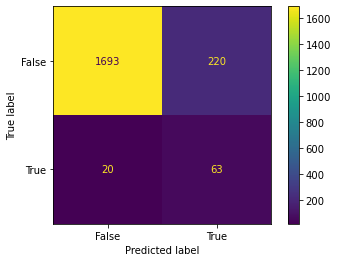

In [17]:
# Plot a confusion matrix that shows how my best model performs on my test set
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

This matrix is a great reminder of how imbalanced my data is, and of why accuracy isn't always the best metric for judging whether or not a model is giving me what I want. After all, if 95% of the companies in my dataset didn't go bankrupt, all the model has to do is always predict `{"bankrupt": False}`, and it'll be right 95% of the time. The accuracy score will be amazing, but it won't tell me what I really need to know.

Instead, I can evaluate my model using two new metrics: **precision** and **recall**.  The precision score is important when I want my model to only predict that a company will go bankrupt if its very confident in its prediction. The *recall* score is important if I want to make sure to identify all the companies that will go bankrupt, even if that means being incorrect sometimes. 

I'll start with a report I can create with scikit-learn to calculate both metrics. Then I'll look at them one-by-one using a visualization tool I've built.

**Classification Report**

In [18]:
classification_report(y_test, model.predict(X_test))

'              precision    recall  f1-score   support\n\n       False       0.99      0.88      0.93      1913\n        True       0.22      0.76      0.34        83\n\n    accuracy                           0.88      1996\n   macro avg       0.61      0.82      0.64      1996\nweighted avg       0.96      0.88      0.91      1996\n'

In [19]:
# Print the classification report for my model, using the test set
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.88      0.93      1913
        True       0.22      0.76      0.34        83

    accuracy                           0.88      1996
   macro avg       0.61      0.82      0.64      1996
weighted avg       0.96      0.88      0.91      1996



**Recall**

In [20]:
model.predict(X_test)[:5]

array([False,  True, False,  True, False])

In [21]:
model.predict_proba(X_test)

array([[0.91792111, 0.08207889],
       [0.48128357, 0.51871643],
       [0.91139529, 0.08860471],
       ...,
       [0.41184649, 0.58815351],
       [0.40714515, 0.59285485],
       [0.94706698, 0.05293302]])

In [22]:
model.predict_proba(X_test)[:5, -1]

array([0.08207889, 0.51871643, 0.08860471, 0.52064087, 0.07456647])

I'll create an interactive dashboard that shows how company profit and losses change in relationship to my model's probability threshold. I'll start with the `make_cnf_matrix` function, which should calculate and print profit/losses, and display a confusion matrix. Then I'll create a FloatSlider `thresh_widget` that ranges from 0 to 1. Finally I'll combine my function and slider in the `interact` function.

In [23]:
model.predict_proba(X_test)[:, -1]

array([0.08207889, 0.51871643, 0.08860471, ..., 0.58815351, 0.59285485,
       0.05293302])

In [24]:
threshold = 0.5
y_pred_proba = model.predict_proba(X_test)[:, -1]
y_pred_proba > threshold

array([False,  True, False, ...,  True,  True, False])

In [25]:
threshold = 0.05
y_pred_proba = model.predict_proba(X_test)[:, -1]
y_pred_proba > threshold

array([ True,  True,  True, ...,  True,  True,  True])

In [26]:
threshold = 0.5
y_pred_proba = model.predict_proba(X_test)[:, -1]
y_pred = y_pred_proba > threshold
confusion_matrix(y_test, y_pred)

array([[1693,  220],
       [  20,   63]])

In [27]:
threshold = 0.8
y_pred_proba = model.predict_proba(X_test)[:, -1]
y_pred = y_pred_proba > threshold
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
tp * 100_000_000

3200000000

In [28]:
threshold = 0.2
y_pred_proba = model.predict_proba(X_test)[:, -1]
y_pred = y_pred_proba > threshold
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
tp * 100_000_000

7800000000

Profit: €7800000000
Losses: €212750000000


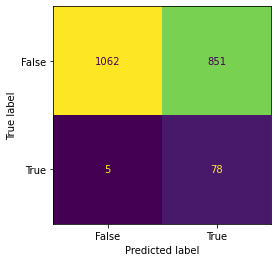

In [29]:
threshold = 0.2
y_pred_proba = model.predict_proba(X_test)[:, -1]
y_pred = y_pred_proba > threshold
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print(f"Profit: €{tp * 100_000_000}")
print(f"Losses: €{fp * 250_000_000}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False);

In [30]:
def make_cnf_matrix(threshold):
    y_pred_proba = model.predict_proba(X_test)[:, -1]
    y_pred = y_pred_proba > threshold
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"Profit: €{tp * 100_000_000}")
    print(f"Losses: €{fp * 250_000_000}")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False)
    



thresh_widget = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

# Communicate

In [31]:
# Save my best-performing model to a file named "model-5-4.pkl"
with open("model-5-4.pkl", "wb") as f:
    pickle.dump(model, f)

**"My Predictor" Module**

I'll open the file `my_predictor_poland.py`, add the `wrangle` and `make_predictions` functions from the last project, and add all the necessary import statements to the top of the file. Once I'm done, I'll save the file.

In [32]:
%%bash

cat my_predictor_poland.py

# Import libraries
import gzip
import json
import pickle

import pandas as pd

def wrangle(filename):
    with gzip.open(filename, "r") as f:
        data = json.load(f)
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")                 
    return df

def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series w/ name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="bankrupt")
    return y_test_pred

I've created my first module.

**Import Module**

I'll import my `make_predictions` function from my `my_predictor` module, and I'll use the code below to make sure it works as expected.

In [54]:
# Import your module
from my_predictor_lesson import make_predictions
    
# Generate predictions
y_test_pred = make_predictions(
    data_filepath="data/poland-bankruptcy-data-2009-mvp-features.json.gz",
    model_filepath="model-5-4.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (526,)


company_id
4     False
32    False
34     True
36    False
40     True
Name: bankrupt, dtype: bool